# STEP 1 : LOADING DATASET AND PREPARING FOR TRAINING

In [2]:
!pip install medmnist

In [3]:
import medmnist
from medmnist import OCTMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = OCTMNIST(split='train', transform=basic_transform, download=True)
validation_dataset   = OCTMNIST(split='val', transform=basic_transform, download=True)
test_dataset  = OCTMNIST(split='test', transform=basic_transform, download=True)

In [6]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader   = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
from medmnist import INFO

info = INFO['octmnist']

print("Train samples:", len(train_dataset))
print("Validation samples:", len(validation_dataset))
print("Test samples:", len(test_dataset))
print("Number of classes:", len(info['label']))
print("Class labels:", info['label'])
print("Image shape:", train_dataset[0][0].shape)

Train samples: 97477
Validation samples: 10832
Test samples: 1000
Number of classes: 4
Class labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
Image shape: torch.Size([1, 28, 28])


**Dataset Overview (OCTMNIST)**

The OCTMNIST dataset consists of 2D grayscale optical coherence tomography (OCT) images used for retinal disease classification. Each image has a size of 28 × 28 pixels with 1 channel. The dataset contains 97,477 training samples, 10,832 validation samples, and 1,000 test samples, which are split among 4 classes: choroidal neovascularization, diabetic macular edema, drusen, and normal retina.

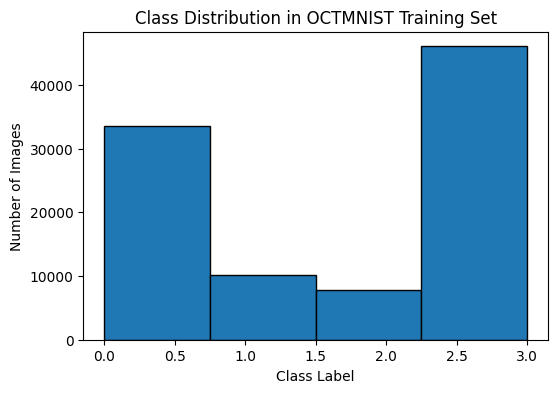

In [8]:
# class distribution histogram
train_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]

plt.figure(figsize=(6,4))
plt.hist(train_labels, bins=4, edgecolor='black')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution in OCTMNIST Training Set")
plt.show()

This histogram shows the distribution of images across the four OCTMNIST classes. It shows an imbalanced class distribution in the OCTMNIST training set, with Classes 0 and 3 having significantly more samples than Classes 1 and 2. Class 3 has the highest number of images, while Class 2 has the fewest.

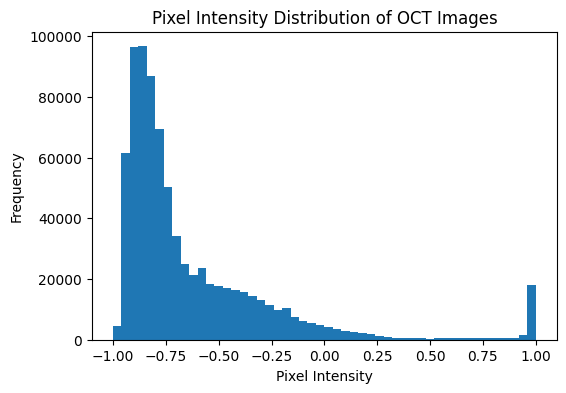

In [9]:
# Pixel intensity distribution

pixels = []

for i in range(1000):
    image, _ = train_dataset[i]
    pixels.extend(image.flatten().numpy())

pixels = np.array(pixels)

plt.figure(figsize=(6,4))
plt.hist(pixels, bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution of OCT Images")
plt.show()

This plot shows the distribution of pixel intensity values across OCT images.

Most pixel values are clustered toward the left end (around -1 to -0.5), meaning the images are largely dark or low-intensity.
There’s a long tail toward brighter values, with a small spike near 1.0, suggesting some very bright regions in the images.

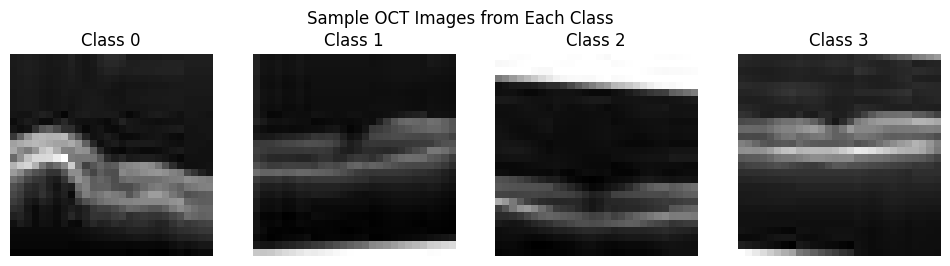

In [10]:
# Sample images from each class

fig, axes = plt.subplots(1, 4, figsize=(12,3))
shown_classes = set()
i = 0

while len(shown_classes) < 4:
    image, label = train_dataset[i]
    label = label.item()

    if label not in shown_classes:
        axes[label].imshow(image.squeeze(), cmap='gray')
        axes[label].set_title(f"Class {label}")
        axes[label].axis('off')
        shown_classes.add(label)
    i = i + 1

plt.suptitle("Sample OCT Images from Each Class")
plt.show()

The figure shows one sample OCT image from each of the four classes, which shows the visible structural differences across categories. We can notice variations in layer thickness, brightness patterns, and distortions, which likely help the model distinguish between the classes.

In [11]:
# Load pre-split datasets

train_dataset = OCTMNIST(
    split='train',
    transform=basic_transform,
    download=True
)

validation_dataset = OCTMNIST(
    split='val',
    transform=basic_transform,
    download=True
)

test_dataset = OCTMNIST(
    split='test',
    transform=basic_transform,
    download=True
)


# STEP 2 : DEFINING THE NEURAL NETWORK

### Neural Network Architecture Description

* This model is a Convolutional Neural Network (CNN) designed for classifying OCT images into 4 classes.
* The input has 1 channel (grayscale image).
* Based on the architecture (128 × 3 × 3 before flattening), the input image size is 28 × 28 pixels.
* There are 4 output neurons, one for each class.
* For the hidden layers, ReLU (Rectified Linear Unit) activation is used.
* There is no activation function applied in the final layer. This is because CrossEntropyLoss is used during training, which internally applies Softmax by itself.
* The model has:
	*	6 convolutional hidden layers
	*	1 fully connected hidden layer (256 neurons)
* The size of he hidden layers is as below
	*	Conv layers: 32 filters → 64 filters → 128 filters
	*	Fully connected hidden layer: 256 neurons
* A Dropout layer with 0.3 probability is used in the fully connected part to reduce overfitting.



In [12]:
!pip install torchinfo

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [14]:
class OCTMNIST_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [15]:
model = OCTMNIST_CNN(num_classes=4)

# Print model summary
summary(
    model,
    input_size=(1, 1, 28, 28),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
OCTMNIST_CNN                             [1, 1, 28, 28]            [1, 4]                    --                        True
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 128, 3, 3]            --                        True
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 28, 28]           320                       True
│    └─ReLU: 2-2                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Conv2d: 2-3                       [1, 32, 28, 28]           [1, 32, 28, 28]           9,248                     True
│    └─ReLU: 2-4                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─MaxPool2d: 2-5                    [1, 32, 28, 28]           [1, 32, 14, 14]           --                        --
│    └─Co

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
OCTMNIST_CNN                             [1, 1, 28, 28]            [1, 4]                    --                        True
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 128, 3, 3]            --                        True
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 28, 28]           320                       True
│    └─ReLU: 2-2                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Conv2d: 2-3                       [1, 32, 28, 28]           [1, 32, 28, 28]           9,248                     True
│    └─ReLU: 2-4                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─MaxPool2d: 2-5                    [1, 32, 28, 28]           [1, 32, 14, 14]           --                        --
│    └─Co

# STEP 3: TRAINING THE NEURAL NETWORK

In [16]:
def train_model(model, epochs=40, lr=0.0003, model_path="best_model.pth"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=5e-5
)

    best_validation_loss = float("inf")

    train_losses, validation_losses = [], []
    training_accuracy, validations_accuracy = [], []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        model.eval()
        validation_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                validation_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        validation_loss /= len(validation_loader)
        validation_accuracy = correct / total

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), model_path)

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_accuracy.append(train_accuracy)
        validation_accuracy.append(validation_accuracy)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
            f"Val Loss: {validation_loss:.4f}, Acc: {validation_accuracy:.4f}"
        )

    end_time = time.time()
    training_time = end_time - start_time

    print(f"\nTraining Time: {training_time:.2f} seconds")

    return model, train_losses, validation_losses, training_accuracy, validations_accuracy, training_time

In [17]:
base_model = OCTMNIST_CNN()
base_model, base_model_train_losses, base_model_validation_losses, base_model_train_accuracy, base_model_validation_accuracy, base_model_training_time = train_model(base_model, epochs=20, lr=0.0005, model_path="base_model.pth")

Epoch [1/20] | Train Loss: 0.8311, Acc: 0.6701 | Val Loss: 0.5529, Acc: 0.8085
Epoch [2/20] | Train Loss: 0.4948, Acc: 0.8297 | Val Loss: 0.4160, Acc: 0.8576
Epoch [3/20] | Train Loss: 0.4009, Acc: 0.8627 | Val Loss: 0.3766, Acc: 0.8679
Epoch [4/20] | Train Loss: 0.3471, Acc: 0.8801 | Val Loss: 0.3450, Acc: 0.8842
Epoch [5/20] | Train Loss: 0.3102, Acc: 0.8916 | Val Loss: 0.2896, Acc: 0.8985
Epoch [6/20] | Train Loss: 0.2791, Acc: 0.9035 | Val Loss: 0.2717, Acc: 0.9065
Epoch [7/20] | Train Loss: 0.2647, Acc: 0.9082 | Val Loss: 0.2765, Acc: 0.9065
Epoch [8/20] | Train Loss: 0.2486, Acc: 0.9144 | Val Loss: 0.2619, Acc: 0.9096
Epoch [9/20] | Train Loss: 0.2314, Acc: 0.9201 | Val Loss: 0.2734, Acc: 0.9082
Epoch [10/20] | Train Loss: 0.2191, Acc: 0.9252 | Val Loss: 0.2440, Acc: 0.9179
Epoch [11/20] | Train Loss: 0.2058, Acc: 0.9293 | Val Loss: 0.2480, Acc: 0.9145
Epoch [12/20] | Train Loss: 0.1949, Acc: 0.9325 | Val Loss: 0.2487, Acc: 0.9166
Epoch [13/20] | Train Loss: 0.1842, Acc: 0.9369 |

In [18]:
base_model = OCTMNIST_CNN()
base_model.load_state_dict(torch.load("base_model.pth"))
base_model = base_model.to(device)
base_model.eval()

OCTMNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (

In [19]:
def evaluate_model(model):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    test_accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    print(f"Test Accuracy : {test_accuracy:.4f}")
    print(f"Precision     : {precision:.4f}")
    print(f"Recall        : {recall:.4f}")
    print(f"F1 Score      : {f1:.4f}")

    return test_accuracy, precision, recall, f1, all_preds, all_labels, all_probs

In [20]:
base_model_test_accuracy, base_model_precision, base_model_recall, base_model_f1, base_model_all_preds, base_model_all_labels, base_model_all_probs = evaluate_model(base_model)

Test Accuracy : 0.7740
Precision     : 0.8127
Recall        : 0.7740
F1 Score      : 0.7601


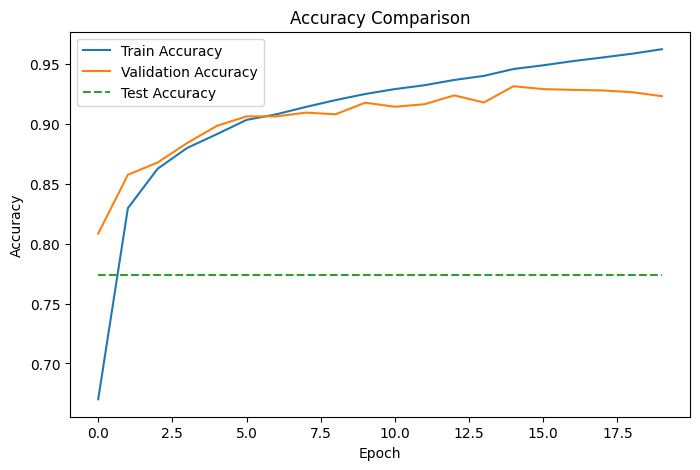

In [21]:
epochs = 20
test_accuracy_line = [base_model_test_accuracy] * epochs

plt.figure(figsize=(8,5))
plt.plot(base_model_train_accuracy, label="Train Accuracy")
plt.plot(base_model_validation_accuracy, label="Validation Accuracy")
plt.plot(test_accuracy_line, label="Test Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.show()

The training accuracy keeps improving and gets very high upto 96%, while the validation accuracy improves at first and then remains almost at the same level .
The test accuracy is much lower than both, which means the model does not perform as well on completely new data.

Best Validation Loss: 0.2238378726384219


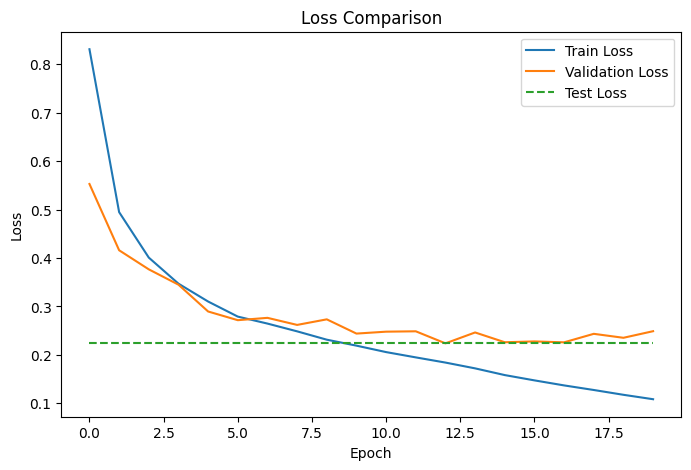

In [22]:
best_validation_loss = min(base_model_validation_losses)
print("Best Validation Loss:", best_validation_loss)

test_loss_line = [best_validation_loss] * epochs

plt.figure(figsize=(8,5))
plt.plot(base_model_train_losses, label="Train Loss")
plt.plot(base_model_validation_losses, label="Validation Loss")
plt.plot(test_loss_line, label="Test Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

The training loss keeps decreasing over time, showing the model is learning the training data well. The validation loss decreases at first but then remains in the same level later, while the test loss stays higher, suggesting the model may be slightly overfitting.

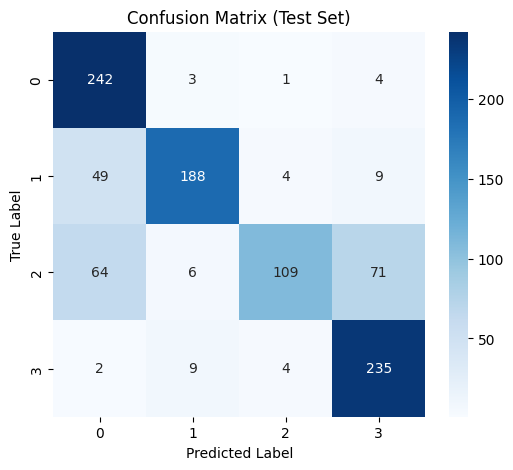

In [23]:
cm = confusion_matrix(base_model_all_labels, base_model_all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

The matrix shows that most predictions are correct (high numbers on the diagonal), especially for Classes 0 and 3. However, Class 2 is often confused with Classes 0 and 3, showing the model struggles more with that class.

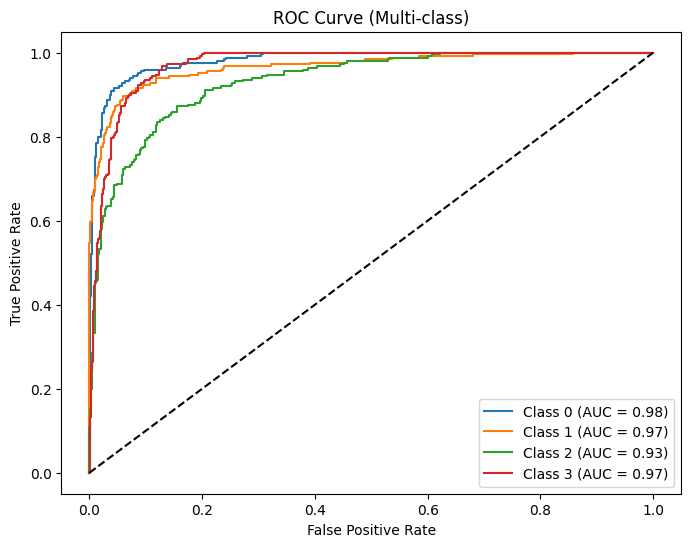

In [24]:
n_classes = len(np.unique(base_model_all_labels))
labels_bin = label_binarize(base_model_all_labels, classes=range(n_classes))

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], base_model_all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-class)")
plt.legend()
plt.show()

The ROC curves are close to the top-left corner, which means the model can distinguish the classes very well. All classes have high AUC values (around 0.93–0.98), showing strong overall classification performance. Among these classes class 2 has the lowest auc value.

# IMPROVISATIONS

# EARLY STOPPING

In [74]:
# Early stopping -> implementing on base model

def train_model_improved_es(model, epochs=20, lr=0.001,model_path="best_model.pth",patience=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    best_validation_loss = float("inf")
    early_stop_counter = 0

    train_losses, validation_losses = [], []
    training_accuracy, validations_accuracy = [], []

    start_time = time.time()

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        model.eval()
        validation_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        validation_loss /= len(validation_loader)
        validation_accuracy = correct / total

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            if epoch == 0 or validation_loss < best_validation_loss:
              best_validation_loss = validation_loss
              torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        training_accuracy.append(train_accuracy)
        validations_accuracy.append(validation_accuracy)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
            f"Val Loss: {validation_loss:.4f}, Acc: {validation_accuracy:.4f}"
        )

    training_time = time.time() - start_time
    print(f"\nTraining Time: {training_time:.2f} seconds")

    return model, train_losses, validation_losses, training_accuracy, validations_accuracy, training_time



improved_model_es = OCTMNIST_CNN()
improved_model_es, model_train_losses_es, model_validation_losses_es, model_train_accuracy_es, model_validation_accuracy_es, model_training_time_es = train_model_improved_es(improved_model_es,epochs=10,lr=0.001,model_path="improved_model_es.pth")

improved_model_es = OCTMNIST_CNN().to(device)
improved_model_es.load_state_dict(torch.load("improved_model_es.pth"))
improved_model_es.eval()

improved_model_test_accuracy_es, improved_model_precision_es, improved_model_recall_es, improved_model_f1_es, improved_model_all_preds_es, improved_model_all_labels_es, improved_model_all_probs_es = evaluate_model(improved_model_es)

Epoch [1/10] | Train Loss: 0.7624, Acc: 0.7138 | Val Loss: 0.4815, Acc: 0.8399
Epoch [2/10] | Train Loss: 0.4823, Acc: 0.8371 | Val Loss: 0.4018, Acc: 0.8635
Epoch [3/10] | Train Loss: 0.4303, Acc: 0.8528 | Val Loss: 0.3703, Acc: 0.8724
Epoch [4/10] | Train Loss: 0.3972, Acc: 0.8633 | Val Loss: 0.3547, Acc: 0.8764
Epoch [5/10] | Train Loss: 0.3781, Acc: 0.8694 | Val Loss: 0.3270, Acc: 0.8877
Epoch [6/10] | Train Loss: 0.3625, Acc: 0.8742 | Val Loss: 0.3164, Acc: 0.8924
Epoch [7/10] | Train Loss: 0.3522, Acc: 0.8781 | Val Loss: 0.3271, Acc: 0.8880
Epoch [8/10] | Train Loss: 0.3439, Acc: 0.8801 | Val Loss: 0.3095, Acc: 0.8950
Epoch [9/10] | Train Loss: 0.3358, Acc: 0.8837 | Val Loss: 0.2965, Acc: 0.9001
Epoch [10/10] | Train Loss: 0.3299, Acc: 0.8870 | Val Loss: 0.2916, Acc: 0.9017

Training Time: 112.35 seconds
Test Accuracy : 0.6290
Precision     : 0.5127
Recall        : 0.6290
F1 Score      : 0.5441


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The above method used Early Stopping, which stops training if validation loss does not improve, helping prevent overfitting and saving training time. It uses the Adam optimizer, which adapts the learning rate automatically and helps the model learn faster and more efficiently.

This was implemented on the base model, which has a Dropout (0.3) in the fully connected layer to reduce overfitting by randomly turning off some neurons during training.

# DATA AUGMENTATION

In [25]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.9, 1.0)),
    transforms.RandomRotation(7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = OCTMNIST(split='train', transform=train_transform, download=True)
validation_dataset = OCTMNIST(split='val', transform=test_transform, download=True)
test_dataset = OCTMNIST(split='test', transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [26]:
# Fix Imabalanced class
train_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]
class_counts = Counter(train_labels)

num_classes = len(class_counts)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_samples = sum(class_counts.values())

class_weights = torch.tensor(
    [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)],
    dtype=torch.float
).to(device)


# BATCH NORM + DATA AUG + LR SCHEDULER + EARLY STOPPING

In [43]:
class Improved_OCTMNIST_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [78]:
model = Improved_OCTMNIST_CNN(num_classes=4)

summary(
    model,
    input_size=(1, 1, 28, 28),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Improved_OCTMNIST_CNN                    [1, 1, 28, 28]            [1, 4]                    --                        True
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 128, 3, 3]            --                        True
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 28, 28]           320                       True
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           [1, 32, 28, 28]           64                        True
│    └─ReLU: 2-3                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           [1, 32, 28, 28]           9,248                     True
│    └─BatchNorm2d: 2-5                  [1, 32, 28, 28]           [1, 32, 28, 28]           64                        True
│    

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Improved_OCTMNIST_CNN                    [1, 1, 28, 28]            [1, 4]                    --                        True
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 128, 3, 3]            --                        True
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 32, 28, 28]           320                       True
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           [1, 32, 28, 28]           64                        True
│    └─ReLU: 2-3                         [1, 32, 28, 28]           [1, 32, 28, 28]           --                        --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           [1, 32, 28, 28]           9,248                     True
│    └─BatchNorm2d: 2-5                  [1, 32, 28, 28]           [1, 32, 28, 28]           64                        True
│    

In [45]:
def Improved_train_model(model, epochs=40, lr=0.0005, model_path="best_model.pth"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
    )

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=5e-5
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=4
    )

    best_validation_loss = float("inf")
    patience_counter = 0

    train_losses, validation_losses = [], []
    training_accuracy, validations_accuracy = [], []

    start_time = time.time()

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        model.eval()
        validation_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                validation_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        validation_loss /= len(validation_loader)
        validation_accuracy = correct / total

        scheduler.step(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        training_accuracy.append(train_accuracy)
        validations_accuracy.append(validation_accuracy)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Acc: {train_accuracy:.4f} | "
            f"Val Acc: {validation_accuracy:.4f}"
        )

        if patience_counter >= 10:
            print("Early stopping triggered.")
            break

    training_time = time.time() - start_time
    print(f"\nTraining Time: {time.time() - start_time:.2f} seconds")

    return model, train_losses, validation_losses, training_accuracy, validations_accuracy, training_time


improved_model = Improved_OCTMNIST_CNN()

improved_model, improved_model_train_losses, improved_model_validation_losses, improved_model_train_accuracy, improved_model_validation_accuracy, improved_model_training_time = Improved_train_model(improved_model, epochs=10, lr=0.0003, model_path="improved_model.pth")

improved_model = Improved_OCTMNIST_CNN().to(device)
improved_model.load_state_dict(torch.load("improved_model.pth"))
improved_model.eval()

improved_model_test_accuracy, improved_model_precision, improved_model_recall, improved_model_f1, improved_model_all_preds, improved_model_all_labels, improved_model_all_probs = evaluate_model(improved_model)

Epoch [1/10] | Train Acc: 0.7128 | Val Acc: 0.8445
Epoch [2/10] | Train Acc: 0.7903 | Val Acc: 0.8418
Epoch [3/10] | Train Acc: 0.8124 | Val Acc: 0.7855
Epoch [4/10] | Train Acc: 0.8247 | Val Acc: 0.8578
Epoch [5/10] | Train Acc: 0.8348 | Val Acc: 0.7733
Epoch [6/10] | Train Acc: 0.8389 | Val Acc: 0.7834
Epoch [7/10] | Train Acc: 0.8429 | Val Acc: 0.8431
Epoch [8/10] | Train Acc: 0.8476 | Val Acc: 0.8599
Epoch [9/10] | Train Acc: 0.8530 | Val Acc: 0.8700
Epoch [10/10] | Train Acc: 0.8549 | Val Acc: 0.8660

Training Time: 109.15 seconds
Test Accuracy : 0.8260
Precision     : 0.8261
Recall        : 0.8260
F1 Score      : 0.8211


In the above method, data augmentation (random crop, rotation, and horizontal flip) is first implemented. This will help the model see slightly different versions of images and will help it generalize better. I also handled class imbalance by using class weights in the loss function, which helps the model pay more attention to underrepresented classes.

Batch Normalization is then added to the model to make training more stable and faster, and Dropout (0.3) to reduce overfitting. Label smoothing helps to make predictions less overconfident, and weight decay helps it to prevent the model from becoming too complex.

The Adam optimizer was used to improve training efficiency. The learning rate scheduler (ReduceLROnPlateau) automatically lowers the learning rate when validation loss stops improving.

These improvements increased test accuracy significantly (to little more than 82%)

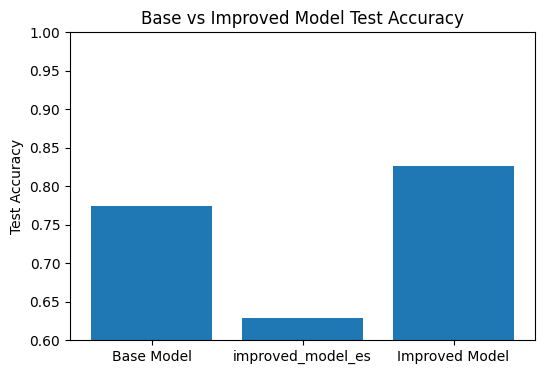

In [76]:
import matplotlib.pyplot as plt

models = ['Base Model', 'improved_model_es', 'Improved Model']
accuracies = [base_model_test_accuracy, improved_model_test_accuracy_es, improved_model_test_accuracy]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel("Test Accuracy")
plt.title("Base vs Improved Model Test Accuracy")
plt.ylim(0.6, 1.0)
plt.show()

In [47]:
best_model = improved_model

In [48]:
print(best_model)

Improved_OCTMNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

# STEP 4 : MODEL’S INTERPRETABILITY

In [61]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Improved_OCTMNIST_CNN(num_classes=4).to(device)
model.load_state_dict(torch.load("improved_model.pth", map_location=device))
model.eval()

images, labels = next(iter(test_loader))
input_image = images[0:1].to(device)

In [62]:
feature_maps = {}

def get_feature_map(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

model.features[0].register_forward_hook(get_feature_map("conv1"))
model.features[5].register_forward_hook(get_feature_map("conv2"))
model.features[10].register_forward_hook(get_feature_map("conv3"))

with torch.no_grad():
    _ = model(input_image)

In [63]:
def visualize_feature_maps(feature_map, title, num_maps=8):
    fmap = feature_map[0].cpu()
    fig, axes = plt.subplots(1, num_maps, figsize=(15,4))

    for i in range(num_maps):
        axes[i].imshow(fmap[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()

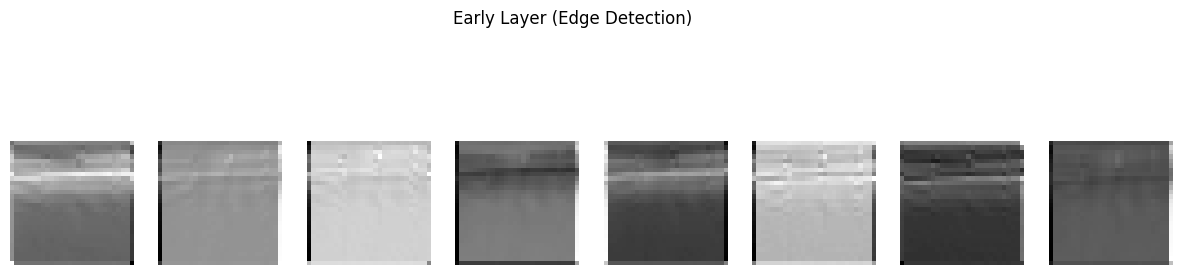

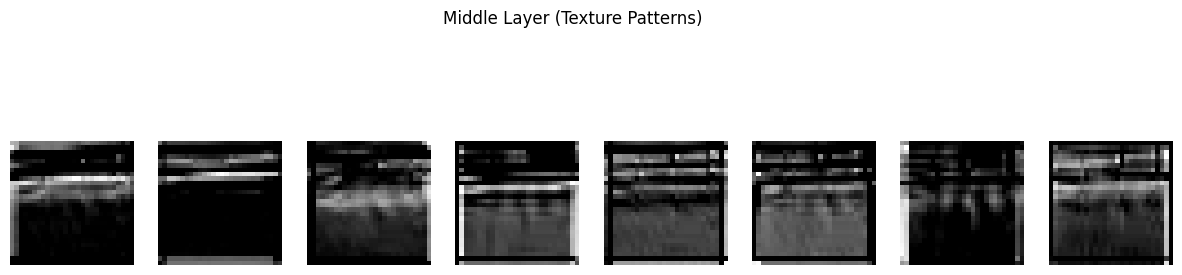

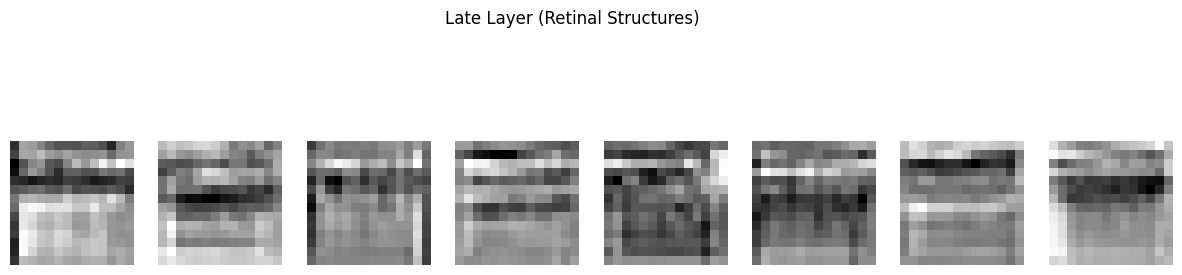

In [64]:
visualize_feature_maps(feature_maps["conv1"], "Early Layer (Edge Detection)")
visualize_feature_maps(feature_maps["conv2"], "Middle Layer (Texture Patterns)")
visualize_feature_maps(feature_maps["conv3"], "Late Layer (Retinal Structures)")

In [65]:
activation_maps = {}

def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach()
    return hook

model.features[1].register_forward_hook(get_activation("relu1"))
model.features[6].register_forward_hook(get_activation("relu2"))
model.features[11].register_forward_hook(get_activation("relu3"))

with torch.no_grad():
    _ = model(input_image)

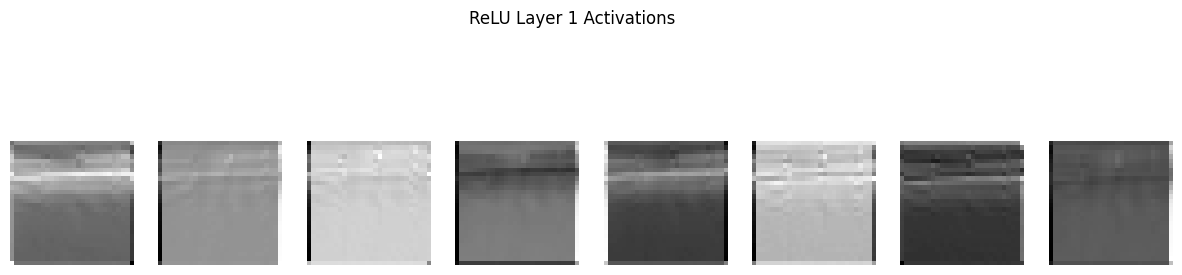

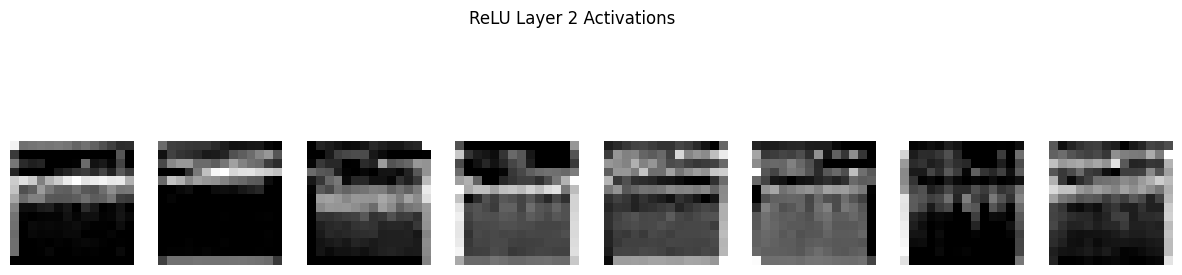

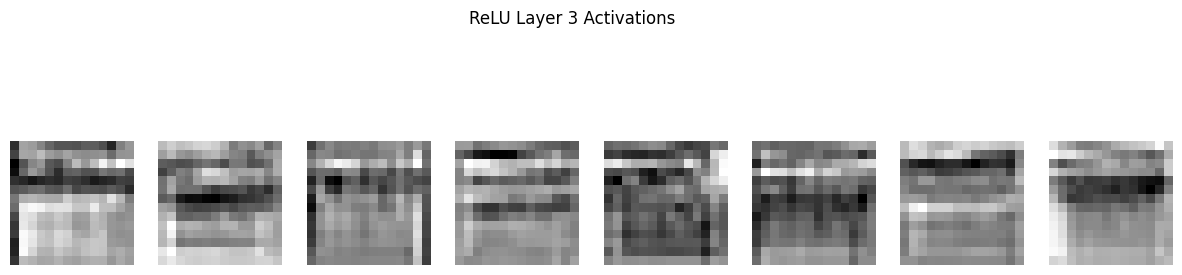

In [66]:
visualize_feature_maps(activation_maps["relu1"], "ReLU Layer 1 Activations")
visualize_feature_maps(activation_maps["relu2"], "ReLU Layer 2 Activations")
visualize_feature_maps(activation_maps["relu3"], "ReLU Layer 3 Activations")

In the early layers, the network mainly highlights the bright retinal layer boundaries and strong horizontal edges, while darker background areas are mostly suppressed.

In the deeper layers, it focuses more on specific patterns like layer thickness changes and abnormal bright regions. It ignores the smooth or uniform areas that are less important.

In [67]:
kernels = model.features[0].weight.data.cpu()

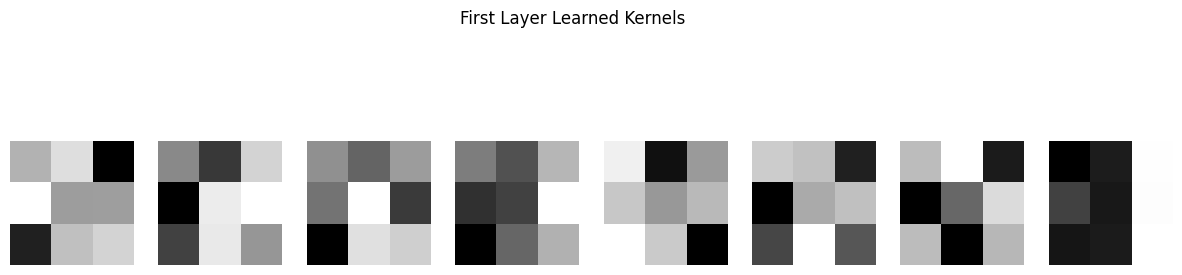

In [68]:
def visualize_kernels(kernels, num_kernels=8):
    fig, axes = plt.subplots(1, num_kernels, figsize=(15,4))

    for i in range(num_kernels):
        kernel = kernels[i][0]
        axes[i].imshow(kernel, cmap='gray')
        axes[i].axis('off')

    plt.suptitle("First Layer Learned Kernels")
    plt.show()

visualize_kernels(kernels)